# Imported accesories

In [168]:
import numpy as np
from vector_class import TripleVector
import matplotlib.pyplot as plt
import random
import sys


# Parameters

In [213]:
A0 = 100000 # Bq
Ab = 50 # Bq
h = 10 # m
D_t = 100 # the pause on each point od the grid in s
x_max = 10 # m
y_max = 10 # m
grid = [10, 10] # m
n_bins = 30

radiation = [A0, Ab, D_t]
detector = [h, x_max, y_max, grid]


# Flying over the surface

In [201]:
def I(A0, r, D_t):
    return (1 / (r + 1)**2) * A0 * D_t

def point_source(x_max, y_max):
    return [random.uniform(-x_max, x_max),random.uniform(-y_max, y_max)]

def flyOver(radiation, detector): # grid is a list which tells the number of tiles for x and y
    A0, Ab, D_t = radiation[0], radiation[1], radiation[2]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xes = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    source = point_source(x_max, y_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    intensities_list = []
    grid_x, grid_y = np.zeros((int(N_x), int(N_y))), np.zeros((int(N_x), int(N_y)))
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xes:
        while abs(y) <= y_max:
            drone = TripleVector(x, y, h)
            position = TripleVector(source[0], source[1], 0)
            r_vector = drone - position
            r = r_vector.magnitude()
            intensity = I(A0, r, D_t)
            if Ab*D_t > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*D_t
                intensities_list.append(intensity - Ab*D_t)
            grid_x[n, m], grid_y[n, m] = x, y
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return [intensities, source, intensities_list, grid_x, grid_y]

#  A0, Ab, D_t, h, x_max, y_max, square
measurement = flyOver(radiation, detector)

# print(measurement[0])



# Location from measurement

In [202]:
def close_numbers(measurement, n_bins):
    edge2, edge1 = np.max(measurement[0]), np.min(measurement[0])
    ran = np.linspace(edge1, edge2, n_bins)
    histogram = np.histogram(measurement[2], ran)
    if max(histogram[0]) <= 2:
        sys.exit("Error to many bins - all of them contain less than three points.")
    i = list(histogram[0]).index(max(histogram[0]))
    Range = histogram[1][i:(i+2)]
    n, m = measurement[0].shape
    X, Y = [], []
    for i in range(n):
        for j in range(m):
            if (Range[0] <= measurement[0][i, j] and measurement[0][i, j] <= Range[1]):
                X.append(measurement[3][i, j])
                Y.append(measurement[4][i, j])
    points = [np.array(X), np.array(Y)]
    return points

def circle_center(x, y, w=[]):
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = np.diag(w)
        A = np.dot(W,A)
        b = np.dot(W,b)
    
    # Solve by method of least squares
    c = np.linalg.lstsq(A,b,rcond=None)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return [xc, yc, r]

points = close_numbers(measurement, 40)
circle_values = circle_center(points[0], points[1])

# Error calculation

In [203]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

def combination(radiation, detector, n_bins):
    measurement = flyOver(radiation, detector)
    points = close_numbers(measurement, n_bins)
    circle_values = circle_center(points[0], points[1])
    dr = dist_points(TripleVector(measurement[1][0], measurement[1][1], 0), TripleVector(circle_values[0], circle_values[1], 0))
    return [measurement, x_max, y_max, circle_values, dr]


# vect1 = TripleVector(1, 2, 1)
# vect2 = TripleVector(1, 5, 1)

# print(dist_points(vect1, vect2))


# Visualization

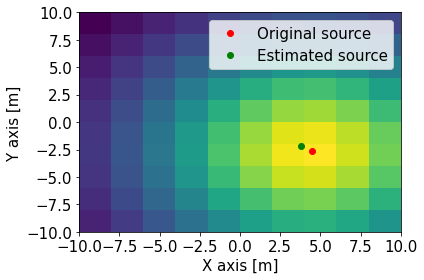

In [217]:
def visualize(measurement, x_max, y_max, circle_values):
    
    plt.imshow(measurement[0], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement[1][0], measurement[1][1]
    plt.plot(X, Y, "o", color = 'r', label = "Original source")
    plt.plot(circle_values[0], circle_values[1], "o", color = 'g', label = "Estimated source")
    # plt.axis("equal")
    plt.xlabel("X axis [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("Y axis [m]", fontsize = 15)
    plt.yticks(fontsize = 15)

   
    plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    # plt.savefig("graphics/test.pdf")
    plt.show()


data = combination(radiation, detector, n_bins)

visualize(data[0], data[1], data[2], data[3])



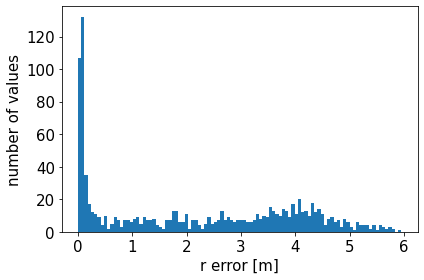

1.8063542785327078


In [212]:
def gauss_r(radiation, detector, n_bins, n_sim):
    R = []
    for i in range(n_sim):
        dr = combination(radiation, detector, n_bins)[-1]
        R.append(dr)
    plt.hist(np.array(R), 100)
    plt.xlabel("r error [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("number of values", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    #plt.savefig("")
    plt.show()

    d_R = np.std(R)

    return d_R

print(gauss_r(radiation, detector, n_bins, 1000))